# 0.0 Understand the Problem

- Purpose of the problem:
    - 1.0 Prediction of the first destination that a new user will choose.
        
    -- Why?
        - What kind of Airbnb business model?
            - Marketplace (Connects people who offer accommodation, with people looking for accommodation)
            - Offer (people offering accommodation)
                - Portfolio Size
                - Diversity / Density of the Portfolio
                - Average rental price
                                
            - Demand (people looking for accommodation)
                - Number of users
                - LTV (Lifetime Value)
                - CAC (Client Acquisition Cost)
                
                
                Gross Revenue = (Fee * Customer Number) - CAC
        
- Solution Proposition <br>

    - Forecast model of the first destination of a new user
    - 1.0 Predictions and save to a database table
    - 2.0 API
        - Input: user and its characteristics
        - Output: user and its characteristics with ** destination prediction **
        
    - 16 cycles

# <font color='red'> Ciclo03: Cross Validation for Imbalanced Datas and Fillout NA </font>

## 0.0 Imports

In [1]:
import pandas                           as pd
import numpy                            as np
import seaborn                          as sns

from sklearn     import model_selection as ms
from sklearn     import preprocessing   as pp
from sklearn     import metrics         as m

from keras       import models          as ml
from keras       import layers          as l

from scikitplot  import metrics         as mt

### 0.1 Helper Functions

### 0.2 Loading Data

In [2]:
df_raw = pd.read_csv( 'data/train_users_2.csv', low_memory=True )
df_raw.shape

(213451, 16)

In [3]:
df_sessions = pd.read_csv( 'data/sessions.csv', low_memory=True )
df_sessions.shape

(10567737, 6)

## 1.0 Data Description

In [4]:
df1 = df_raw.copy()

### 1.1 Data Dimension

In [5]:
print( 'Number of rows: {}'.format( df1.shape[0]) )
print( 'Number of columns: {}'.format( df1.shape[1]) )

Number of rows: 213451
Number of columns: 16


In [6]:
print( 'Number of rows: {}'.format( df_sessions.shape[0]) )
print( 'Number of columns: {}'.format( df_sessions.shape[1]) )

Number of rows: 10567737
Number of columns: 6


### 1.2 Data Type

In [7]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [8]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

In [9]:
df1.sample().T

,148065
id,bago4qpr9l
date_account_created,2014-01-31
timestamp_first_active,20140131213215
date_first_booking,NaN
gender,-unknown-
age,23
signup_method,basic
signup_flow,0
language,en
affiliate_channel,content


### 1.3 NA Check

In [10]:
df1.isna().sum() / len( df1 )

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [11]:
df_sessions.isna().sum() / len( df1 )

user_id          0.161611
action           0.373041
action_type      5.276171
action_detail    5.276171
device_type      0.000000
secs_elapsed     0.637294
dtype: float64

In [12]:
# remoe missing values completly
#df1 = df1.dropna()

# ========== User ==========

# date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime( '%Y-%m-%d' )
df1['date_first_booking' ] = df1['date_first_booking'].fillna( date_first_booking_max )

# age
avg_age = df1['age'].mean().astype( int )
df1['age'] = df1['age'].fillna( avg_age )

#first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ========== Sessions ==========

# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]


In [13]:
aux = df1[df1['date_first_booking'].isna()]
aux['country_destination'].value_counts( normalize=True )
# Only the NDF has missing values in this variable. 
# The reason for this occur is that the person didn't do the first booking yet.
# The value that we will fill the missing values is the max day in the 'date_first_booking' column.

Series([], Name: country_destination, dtype: float64)

In [14]:
aux = df1[df1['age'].isna()]
aux['country_destination'].value_counts( normalize=True )

# We can see here that the missing values is proporcional distribuciones among the target values.
# Let's plot a graph which will give us a better visualization of this distribution.

Series([], Name: country_destination, dtype: float64)

/home/victorpereira/.pyenv/versions/3.8.0/envs/airbnb_predict_first_booking/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

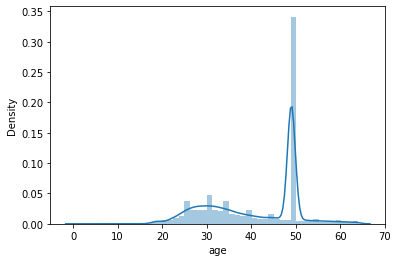

In [15]:
sns.distplot( df1[df1['age'] < 65]['age'] )
# We can see that this variable has a Normal distribution.
# For this reason, in this variable, I will use "mean" to fill the missing values.

In [16]:
df1['first_affiliate_tracked'].drop_duplicates()
# This is a categorical variable. It's very difficult to fill out categorical variables.
# Normally you fill using the frequency method, but the chance to input a bias in the dataset is big.
# As the number of missing values in this case is not so large, I will just drop them. 

0            untracked
5                  omg
13              linked
79       tracked-other
257            product
6270         marketing
11184        local ops
Name: first_affiliate_tracked, dtype: object

In [17]:
df1.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

In [18]:
df_sessions.isna().sum()

user_id          0
action           0
action_type      0
action_detail    0
device_type      0
secs_elapsed     0
dtype: int64

### 1.4 Change Type

In [19]:
# date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( int )

In [20]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

### 1.5 Check Balanced Data

In [21]:
df1['country_destination'].value_counts( normalize=True )

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

### 1.6 Descriptive Analysis

In [22]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

#### 1.6.1 Numerical - Users

In [25]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenated
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,1.0,2014.0,2013.0,49.183142,49.0,118.421689,16.333820,267.655434
1,signup_flow,0.0,25.0,25.0,3.151490,0.0,7.543915,2.287158,3.567794


#### 1.6.2 Numerical - Sessions

## 2.0 Data Filtering

In [22]:
df2 = df1.copy()

### 2.1 Filtering Rows

### 2.2 Column Selection

## 3.0 Data Preparation

In [23]:
df3 = df2.copy()

In [24]:
# dummy variable
df3_dummy = pd.get_dummies( df3.drop( ['id', 'country_destination'], axis=1 ) )

# join id and country destination
df3 = pd.concat( [df3[['id', 'country_destination']], df3_dummy], axis=1 )

## 4.0 Feature Selection

In [25]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking'] # original dates
df4 = df3.drop( cols_drop, axis=1 )

In [26]:
 X = df4.drop( 'country_destination', axis=1 )
y = df4['country_destination'].copy()

In [27]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 )

## 5.0 Machine Learning Model

In [28]:
x_train = X_train.drop( 'id', axis=1 )
x_test = X_test.drop( 'id', axis=1 )

### 5.1 Baseline Model

In [29]:
import random

In [30]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts( normalize=True ).sort_index().tolist()

# Random model
yhat_random = random.choices( population=country_destination_list, 
                             weights=country_destination_weights, 
                             k=k_num)
len( yhat_random )

41478

#### 5.1.1 Baseline Model Performance

Accuracy: 0.42793770191426783
Balanced Accuracy: 0.08428661732694397
Kappa Score: 0.0019941752595137308
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       111
          CA       0.01      0.01      0.01       281
          DE       0.01      0.01      0.01       215
          ES       0.01      0.01      0.01       428
          FR       0.03      0.03      0.03      1021
          GB       0.00      0.00      0.00       426
          IT       0.03      0.02      0.02       570
         NDF       0.58      0.58      0.58     23996
          NL       0.01      0.01      0.01       146
          PT       0.00      0.00      0.00        48
          US       0.30      0.30      0.30     12280
       other       0.05      0.05      0.05      1956

    accuracy                           0.43     41478
   macro avg       0.08      0.08      0.08     41478
weighted avg       0.43      0.43      0.43     41478



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

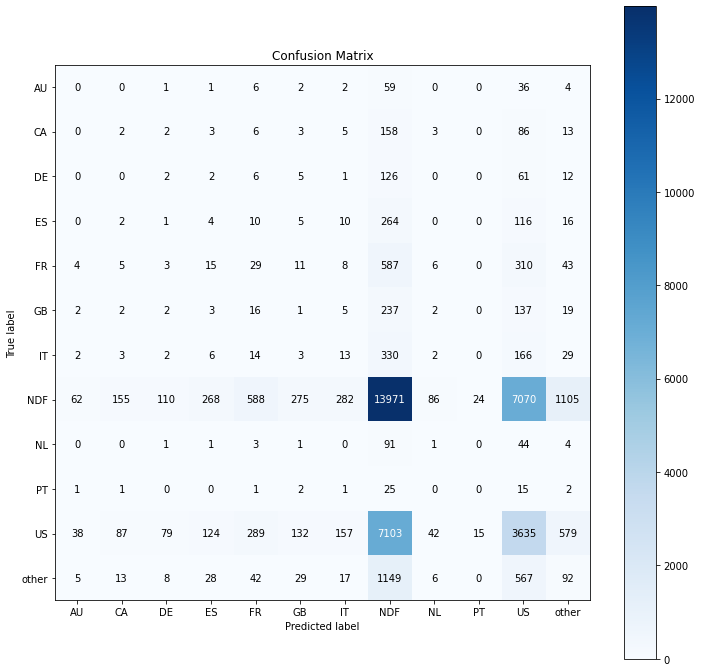

In [31]:
# Accuracy
acc_random = m.accuracy_score( y_test, yhat_random )
print( 'Accuracy: {}'.format( acc_random ) )

# Balanced Accuracy
balanced_accuracy_random = m.balanced_accuracy_score( y_test, yhat_random )
print( 'Balanced Accuracy: {}'.format( balanced_accuracy_random ) )

# Kappa Metrics
kappa_random = m.cohen_kappa_score( y_test, yhat_random )
print( 'Kappa Score: {}'.format( kappa_random ) )

# Classification Report
print( m.classification_report( y_test, yhat_random ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12, 12) )


### 5.2 Neural Network - MLP

In [32]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [33]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 128, input_dim=x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 12, activation='softmax') )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

Epoch 1/100
5185/5185 [==============================] - 3s 502us/step - loss: 1.2387 - accuracy: 0.5893
Epoch 2/100
5185/5185 [==============================] - 3s 485us/step - loss: 1.1520 - accuracy: 0.6097
Epoch 3/100
5185/5185 [==============================] - 3s 488us/step - loss: 1.1171 - accuracy: 0.6173
Epoch 4/100
5185/5185 [==============================] - 3s 527us/step - loss: 1.0977 - accuracy: 0.6187
Epoch 5/100
5185/5185 [==============================] - 3s 487us/step - loss: 1.0900 - accuracy: 0.6196
Epoch 6/100
5185/5185 [==============================] - 3s 494us/step - loss: 1.0883 - accuracy: 0.6198
Epoch 7/100
5185/5185 [==============================] - 3s 630us/step - loss: 1.0862 - accuracy: 0.6206
Epoch 8/100
5185/5185 [==============================] - 3s 631us/step - loss: 1.0853 - accuracy: 0.6207
Epoch 9/100
5185/5185 [==============================] - 3s 624us/step - loss: 1.0842 - accuracy: 0.6213
Epoch 10/100
5185/5185 [==============================]

#### 5.2.1 NN Performance

In [34]:
# prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

Accuracy: 0.6262114856068277
Balanced Accuracy: 0.1070473562459469
Kappa Score: 0.2379464968013203


/home/victorpereira/.pyenv/versions/3.8.0/envs/airbnb_predict_first_booking/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       111
          CA       0.00      0.00      0.00       281
          DE       0.00      0.00      0.00       215
          ES       0.00      0.00      0.00       428
          FR       0.00      0.00      0.00      1021
          GB       0.00      0.00      0.00       426
          IT       0.00      0.00      0.00       570
         NDF       0.67      0.87      0.75     23996
          NL       0.00      0.00      0.00       146
          PT       0.00      0.00      0.00        48
          US       0.50      0.41      0.45     12280
       other       0.00      0.00      0.00      1956

    accuracy                           0.63     41478
   macro avg       0.10      0.11      0.10     41478
weighted avg       0.53      0.63      0.57     41478



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

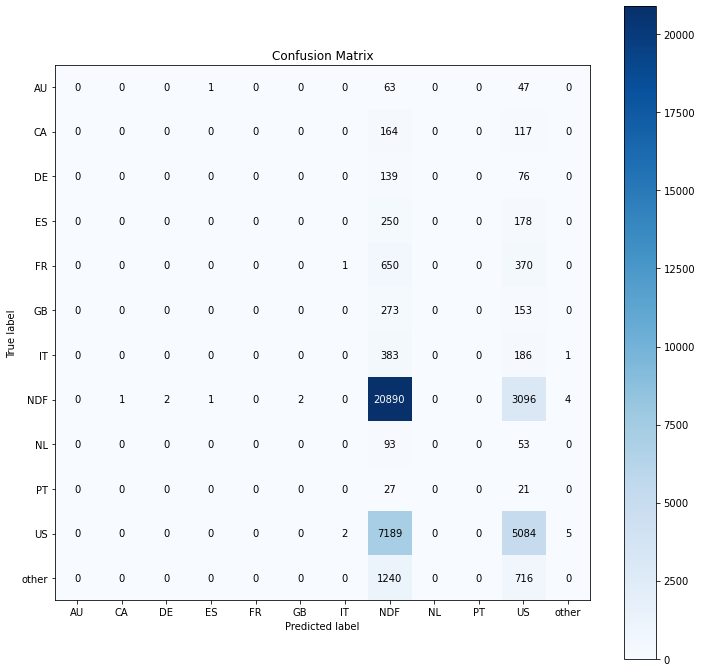

In [35]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print( 'Accuracy: {}'.format( acc_nn ) )

# Balanced Accuracy
balanced_accuracy_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
print( 'Balanced Accuracy: {}'.format( balanced_accuracy_nn ) )

# Kappa Metrics
kappa_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
print( 'Kappa Score: {}'.format( kappa_nn ) )

# Classification Report
print( m.classification_report( y_test_nn, yhat_nn ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12, 12) )


#### 5.2.1 NN Performance - Cross-Validation

In [37]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number:{}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoder
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu') )
    model.add( l.Dense( 12, activation='softmax' ) )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number:1/5
Fold Number:2/5
Fold Number:3/5
Fold Number:4/5
Fold Number:5/5


In [38]:
print( 'Avg Balanced Accuracy: {} +/- {}'.format( np.round( np.mean( balanced_acc_list ), 2 ), 
                                                 np.round( np.std( balanced_acc_list ), 4 ) ) )
print( 'Avg Kappa Accuracy: {} +/- {}'.format( np.round( np.mean( kappa_acc_list ), 4 ), 
                                              np.round( np.std( kappa_acc_list ), 4 ) ) )

Avg Balanced Accuracy: 0.11 +/- 0.0013
Avg Kappa Accuracy: 0.2301 +/- 0.0098
